# What is the True Normal Human Body Temperature? 

#### Background

The mean normal body temperature was held to be 37$^{\circ}$C or 98.6$^{\circ}$F for more than 120 years since it was first conceptualized and reported by Carl Wunderlich in a famous 1868 book. But, is this value statistically correct?

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns

df = pd.read_csv('data/human_body_temperature.csv')

In [2]:
# Your work here.
df.head(3)

,temperature,gender,heart_rate
0,99.3,F,68.0
1,98.4,F,81.0
2,97.8,M,73.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 3 columns):
temperature    130 non-null float64
gender         130 non-null object
heart_rate     130 non-null float64
dtypes: float64(2), object(1)
memory usage: 3.1+ KB


## 1. Is the distribution of body temperatures normal? 

The best way is to visually compare the sample distribution with normal distribution by plotting the both.

In [4]:
def ecdf(data):
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, len(data)+1) / n
    return x, y
x, y = ecdf(df['temperature'])

11


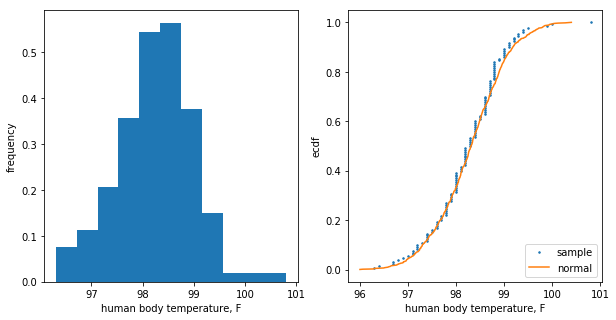

In [5]:
fig, ax = plt.subplots(1,2,figsize=(10, 5))
bins = np.sqrt(len(df))
bins = int(bins)
print(bins)

# Compute mean and standard deviation: mu, sigma
mu = np.mean(df['temperature'])
sigma = np.std(df['temperature'])

# Sample out of a normal distribution with this mu and sigma: samples
samples = np.random.normal(mu, sigma, size=1000)

# Get the CDF of the samples and of the data
x_theor, y_theor = ecdf(samples)


ax[0].hist(df['temperature'], density=True, bins=bins)
ax[0].set_xlabel('human body temperature, F')
ax[0].set_ylabel('frequency')
ax[1].plot(x, y, marker='.', markersize=3, linestyle='none')
ax[1].plot(x_theor, y_theor)
ax[1].set_xlabel('human body temperature, F')
ax[1].set_ylabel('ecdf')
ax[1].legend(('sample', 'normal'), loc='lower right')

plt.show()

In [6]:
# Normalality test using stats function
stats.normaltest(df['temperature'])

NormaltestResult(statistic=2.7038014333192031, pvalue=0.2587479863488254)

The left figure shows the distribution is more or less close to be normal. Empirical cumulative distribution of the corresponding normal distribution is very close to the data, as shown in the right figure. The normaltest() rusults give a high p-value, indicating it is more likely to be a normal distribution. 

## 2. Is the sample size large? Are the observations independent?

In [7]:
print('There are {} oberservations in the sample.'.format(len(df)))

There are 130 oberservations in the sample.


The minimum requirement for sample size is 30 in order to be considered as representive of population distribution. We can say the sample is large enough. It is much less than 10% of hundreds of millions population. And the body temperature of each person doesn't rely on another, so it is independant.

## 3. Is the true population mean really 98.6 degrees F?

### 3.1 Bootstrap hypothesis test
- H0: Population mean is 98.6 degrees F.
- Ha: Population mean is not 98.6 degrees F.

In [8]:
def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = func(np.random.choice(data, size=len(data)))

    return bs_replicates

sample_mean: 98.24923076923078
p-value = 0.0


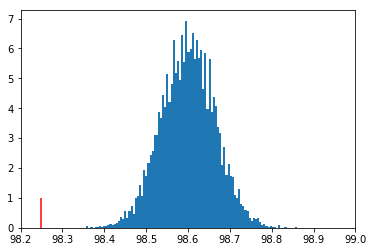

In [9]:
sample = df['temperature']

hypothesis=98.6

sample_mean = np.mean(sample)
print('sample_mean:', sample_mean)

sample_shifted = sample - np.mean(sample) + hypothesis

# Take bootstrap replicates of  temperature
bs_replicates = draw_bs_reps(sample_shifted, np.mean, 10000)

# Compute fraction of replicates that are less than the observed temperature mean: p
p_value = np.sum(bs_replicates < sample_mean) / 10000
print('p-value =', p_value)

plt.hist(bs_replicates, bins=100, density=True)
plt.xlim(98.2, 99.0)

# mark where sample mean is.
plt.vlines(sample_mean, 0, 1, color='r')

plt.show()

Here the hypothesis is the mean of population is 98.6 F. The sample mean is 98.2 degrees F, which is far from population mean, as shown in the figure above. The p-value is zero, strongly rejecting the hypothesis. Therefore, there is very little chance chance that the population mean is 98.6 degrees F if we trust the sampled data.

### 3.2 z-test
The sample size is large enought to do z-test.

In [10]:
# sample variance
sample_var = np.var(df['temperature'], ddof=0)

# sample standard deviation
sample_std = np.std(df['temperature'], ddof=0)

# assuming sample normal distribution and the mean is 98.6F
hypothesis = 98.6

# sample size
n = len(df['temperature'])

# square root for z calculation
sqrtn = np.sqrt(n)

z = (sample_mean - hypothesis) / (sample_std / sqrtn)

print('z:', z)

# p-value
p_val = stats.norm.cdf(z)

print('p-value:', p_val)

z: -5.47592520208
p-value: 2.17615758294e-08


### 3.3 t-test

In [11]:
sample_mean = np.mean(df['temperature'])

sample_var = np.var(df['temperature'], ddof=1)
print('variance by ddof=1:', sample_var)

sample_std = np.std(df['temperature'], ddof=1)
print('std by ddof=1:', sample_std)

hypothesis = 98.6
n = len(df['temperature'])
sqrtn = np.sqrt(n)
t = (sample_mean - hypothesis) / (sample_std / sqrtn)
print('t statistic:', t)
p_val = stats.t.cdf(t, n-1)
print('p-val:', p_val)

variance by ddof=1: 0.5375575432319613
std by ddof=1: 0.7331831580389454
t statistic: -5.45482329236
p-val: 1.20531602078e-07


Here the z-score and t-score are similar. p-values from both test are extremely small, suggesting the hypothesis is wrong. So the population mean is not 98.6 degrees F based on the sampled data.

Both z-test and t-test give very similar results.

## 4. Draw a small sample of size 10 from the data and repeat both frequentist tests

In [12]:
sample = np.random.choice(df['temperature'], size=10)
sample

array([ 97.6,  96.7,  98.4,  98. ,  97.7,  97.8,  99. ,  98.4,  99.5,  98. ])

### 4.1 Bootstrap test

In [13]:
sample_mean = np.mean(sample)
print('sample_mean:', sample_mean)

sample_shifted = sample - np.mean(sample) + 98.6

# Take bootstrap replicates of Frog B's translated impact forces: bs_replicates
# bs_replicates = draw_bs_reps(sample_shifted, diff_from_hypothesis, 10000)

bs_replicates = draw_bs_reps(sample_shifted, np.mean, 10)

# Compute fraction of replicates that are less than the observed temperature mean: p
p_value = np.sum(bs_replicates < sample_mean) / 10000
print('p-value =', p_value)

sample_mean: 98.11
p-value = 0.0


### 4.2 z-test

In [14]:
sample_mean = np.mean(sample)

sample_std = np.std(sample, ddof=0)

hypothesis = 98.6
n = len(sample)
sqrtn = np.sqrt(n)
z = (sample_mean - hypothesis) / (sample_std / sqrtn)
print('z:', z)
p_val = 1- stats.norm.cdf(z)
print('p-value:', p_val)

z: -2.10298492351
p-value: 0.982266456293


### 4.3 t-test

In [15]:
sample_mean = np.mean(sample)

sample_var = np.var(sample, ddof=1)
print('variance:', sample_var)

sample_std = np.std(sample, ddof=1)
print('std:', sample_std)

n = len(sample)
sqrtn = np.sqrt(n)
t = (sample_mean - 98.6) / (sample_std / sqrtn)
print('t statistic:', t)
p_val = stats.t.cdf(t, n-1)
print('p-val:', p_val)

variance: 0.603222222222
std: 0.77667381971
t statistic: -1.99506667299
p-val: 0.0385820131148


With small sample, there is big difference in the results using different test methodology. Bootstrap test shows a p-value close to 0, which is most realistic. P-value from z-test and t-test is 0.8 and 0.2, respectively, which would support the null hypothesis. With such small sample size, both z-test and t-test could lead to draw worong conclusion.

The advantage of using bootstrap method is obvious.

## 5. At what temperature should we consider someone's temperature to be "abnormal"?

### 5.1 Bootstrap approach

In [16]:
bs_replicates = draw_bs_reps(df['temperature'], np.mean, 10000)

# z value for 95% confidence
z = 1.96  

# Calculates margin of error for sample mean with 95% confidence
moe = z * np.std(bs_replicates) / np.sqrt(len(bs_replicates))

print('The margin of error is: ', moe)

# Calculates 95% confidence interval
confidence_interval = np.percentile(bs_replicates, [2.5, 97.5])

print('95% confidence interval is between', confidence_interval[0], 'and', confidence_interval[1])

The margin of error is:  0.00126290429563
95% confidence interval is between 98.1230769231 and 98.3753846154


### 5.2 z-test approach

In [17]:
bs_replicates = draw_bs_reps(df['temperature'], np.mean, 10000)

# z value for 95% confidence
z = 1.96  

# Calculates margin of error for sample mean with 95% confidence
moe = z * np.std(df['temperature']) / np.sqrt(len(df['temperature']))

print('The margin of error is: ', moe)

# Calculates 95% confidence interval
confidence_interval = np.percentile(df['temperature'], [2.5, 97.5])

print('95% confidence interval is between', confidence_interval[0], 'and', confidence_interval[1])

The margin of error is:  0.125550964803
95% confidence interval is between 96.7225 and 99.4775


Again bootstrap approach gives very different results than regular approach. The former has a margin of error of 0.001, which is much smaller than 0.1 of the latter. 

We would prefer the bootstrap approach. So if someone's temperature is lower than 98.12 F or larger than 98.38 F, it is considered 'abnormal'.

## 6. Is there a significant difference between males and females in normal temperature?

This a two sample test for population mean. We make a hypothesis as follows,
- H0: There is no difference in male and female temperature.
- Ha: There is difference in male and female temperature.
We can conveniently use two sample permutation bootstrap method for the null hypothesis test.

### 6.1 Bootstrap approach

In [18]:
def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""

    # Concatenate the data sets: data
    data = np.concatenate((data1, data2))

    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2

def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""

    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)

        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)

    return perm_replicates

def diff(data1, data2):
    return data1.mean() - data2.mean()

male = df['temperature'][df['gender']=='M']
female = df['temperature'][df['gender']=='F']

sample_diff_mean = diff(male, female)

bs_replicates = draw_perm_reps(male, female, diff, size=10000)

p_value = np.sum(bs_replicates <= sample_diff_mean) / len(bs_replicates)

print('p_value: ', p_value)


p_value:  0.0109


P-value is small compared with 0.025. We can reject the hypothesis and conclude that the temperature of male and female is very different.

### 6.3 Frequentist probality approach

In [19]:
# two sample mean comparison statistic calculation
def two_sample_mean(data1, data2):
    diff_mean = data1.mean() - data2.mean()
    n1 = len(data1)
    n2 = len(data2)
    mu1 = data1.mean()
    mu2 = data2.mean()
    var1 = np.var(data1)
    var2 = np.var(data2)
    std_diff = np.sqrt(var1/n1 + var2/n2)
    z = abs((diff_mean) / std_diff)
    p_value = stats.norm.cdf(-z)
    moe = 1.96 * std_diff # 95% confidence
    ci = [diff_mean - moe,  diff_mean + moe]
    return z, p_value, moe, ci

# male and female data input for the funcion
z, p_value, moe, ci = two_sample_mean(male, female)

print('p_value:', p_value)

p_value: 0.0106332259151


p-value from z-test is similar to bootstrap test. 

### 6.4 Visual approach

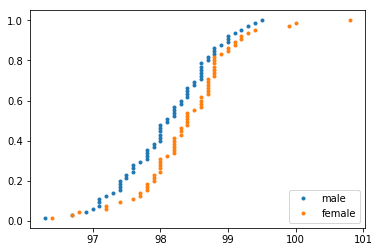

In [20]:
x_M, y_M = ecdf(male)
x_F, y_F = ecdf(female)
plt.plot(x_M, y_M, marker='.', linestyle='none')
plt.plot(x_F, y_F, marker='.', linestyle='none')
plt.legend(('male', 'female'), loc='lower right')
plt.show()

The empirical cumulative distribution plot of male and female also shows clear difference in their body temperature. Obviously females are warmer than males!

## Summary

The orginal question is if the sample mean is population mean 98.6F. Both z-test and t-test denied it on condition of large sample size. When we use small sample, we could draw wrong conclusion. 

It appears the our sample doesn't support the 120 year-old belief that the population average temperatue is 120F.

There is sharp difference in male and female temperature. It is fine if we are noly concerned about the average. However, it would be wise to seperate male and female and do the comparison differently when we treat a specific patient according to the gender. This is not discremination against female. Real care and love demands taking care of the difference in gender.